# Lista de exercícios 2 - Deep Learning

Pedro Augusto Gomes Medeiros - 20210024522

(Sou o que não está matriculado)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import idx2numpy
import pickle

# Questão 1

1-) Implemente uma Rede Neural Artificial que faça a predição se um passageiro sobreviveu ou
não ao acidente do Titanic. Embora houvesse algum elemento de sorte envolvido na
sobrevivência dos envolvidos, aparentemente alguns grupos de pessoas tinham mais
probabilidade de sobreviver do que outros. Neste exercício, você deve tentar criar um modelo
preditivo, usando os dados de passageiros (ou seja, nome, idade, sexo, classe
socioeconômica, etc.), que procure responder à pergunta: "que tipo de pessoa tem mais
probabilidade de sobreviver?"

A base de dados do problema pode ser acessada através do
seguinte link: https://www.kaggle.com/c/titanic/data.

Apresente também a curva do erro médio de treinamento com relação ao número de épocas e
a curva do erro médio com o conjunto de validação ou teste. Calcule e apresente também a
matriz de confusão do modelo.

Dica: Analisem cuidadosamente a base de dados utilizada. Observem que alguns usuários
possuem dados faltantes, inconsistentes, e algumas características (features) são redundantes.
Dessa forma, a aplicação de técnicas de pré-processamento vistas nas nossas aulas pode ser
importante para resolução do problema.


## Pré-processamento

In [5]:
# Dataframe de treino
titanic_train = pd.read_csv('titanic/train.csv')
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [119]:
# Dropando atributos nominais
titanic_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [120]:
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [121]:
titanic_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [6]:
# Preenchendo os valores faltantes da coluna "Age" com a moda
mode_age = titanic_train['Age'].mode()[0]
titanic_train['Age'] = titanic_train['Age'].fillna(mode_age)

In [125]:
embarked_counts = titanic_train['Embarked'].value_counts()
print(embarked_counts)

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [126]:
# Como a maioria esmagadora dos passageiros embarcou no porto S, vamos usar ele pra prencher os 2 que estavam ausentes
titanic_train['Embarked'].fillna('S', inplace=True)

In [128]:
titanic_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [130]:
# Usando o one hot encoder em Embarked, Pclass e Sex
titanic_train = pd.get_dummies(titanic_train, columns=['Embarked', 'Sex', 'Pclass'])

In [132]:
titanic_train.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,False,False,True,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,False,True,False,True,False,False
2,1,26.0,0,0,7.9250,False,False,True,True,False,False,False,True
3,1,35.0,1,0,53.1000,False,False,True,True,False,True,False,False
4,0,35.0,0,0,8.0500,False,False,True,False,True,False,False,True


In [134]:
titanic_train['FamilySize'] = titanic_train['Parch'] + titanic_train['SibSp']
titanic_train = titanic_train.drop(['Parch', 'SibSp'], axis=1)

<Axes: >

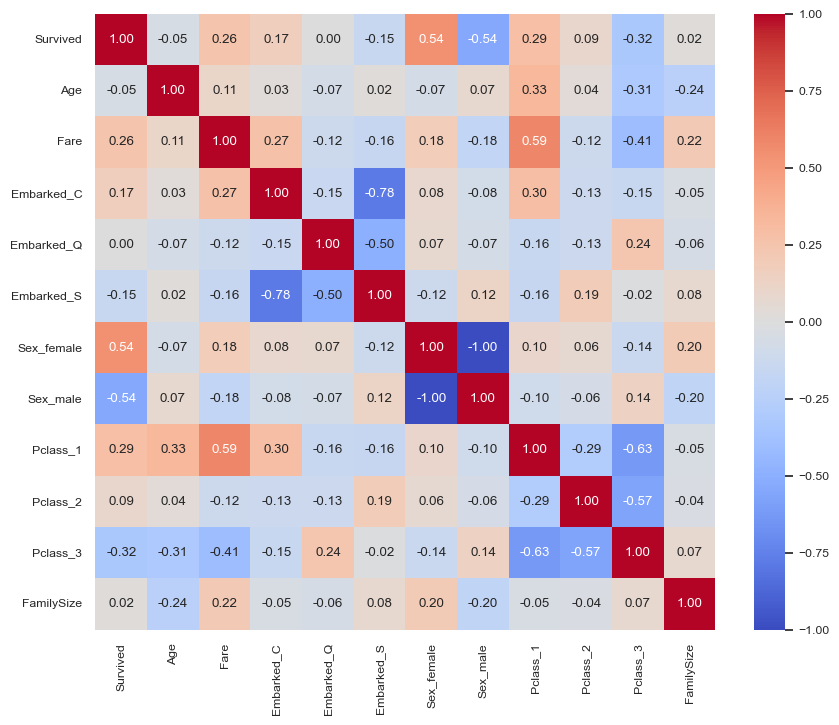

In [135]:
# Plotando a correlação dos atributos
correlation_train = titanic_train.corr() 
sns.set_theme(font_scale=0.8)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_train, annot=True, fmt=".2f", cmap='coolwarm')

In [145]:
# Não tinha nenhuma correlação muito significativa entre os atributos e a saída desejada, então vou manter todos
# Dava pra truncar os atributos que eu passei pelo encoder pra reduzir a dimensionalidade
# Mas irei manter, por questão de legibilidade, já que o mesmo com elas, as tabelas ainda são bem pequenas

In [146]:
fig = px.scatter(titanic_train, x='Fare', hover_data=['Fare'])
fig.show()

In [140]:
# Preenchi os valores de Fare iguais a 0 com a mediana, pra evitar distorções
# Tinham alguns valores bem altos, mas cheuqie e todos estavam na 1º classe, então mantive
titanic_train['Fare'].replace(0, titanic_train['Fare'].median(), inplace=True)

In [141]:
# Como Fare é o valor da passagem, trunquei pra 2 casas decimais
titanic_train['Fare'] = titanic_train['Fare'].round(2)

In [142]:
# Como a idade é um valor inteiro, converti pra int
titanic_train['Age'] = titanic_train['Age'].astype(int)

In [147]:
# Normalizando os valores
scaler = MinMaxScaler()

titanic_train.iloc[:, 1:] = scaler.fit_transform(titanic_train.iloc[:, 1:])
# titanic_test.iloc[:, 1:] = scaler.transform(titanic_test.iloc[:, 1:])

In [148]:
titanic_train

,Survived,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,FamilySize
0,0,0.2750,0.006374,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.1
1,1,0.4750,0.132338,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.1
2,1,0.3250,0.007692,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1,0.4375,0.096573,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.1
4,0,0.4375,0.007948,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0.3375,0.017686,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
887,1,0.2375,0.051129,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
888,0,0.3000,0.038244,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.3
889,1,0.3250,0.051129,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Execução do modelo

In [188]:
# Definição do modelo
# 2 Camadas ocultas com função de ativação ReLU
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

In [189]:
# Preparando os dados
features = titanic_train.drop('Survived', axis=1).values
labels = titanic_train['Survived'].values

features = torch.tensor(features, dtype=torch.float)
labels = torch.tensor(labels, dtype=torch.float).view(-1, 1)

dataset = TensorDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Dividindo os dados em treino e teste
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1, random_state=4)

In [198]:
# Definição dos hiperparametros
input_size = titanic_train.shape[1] - 1
hidden_size1 = 32
hidden_size2 = 16
hidden_size3 = 16
learning_rate = 0.001
num_epochs = 10

model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [199]:
# Treinando o modelo
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Treinamento
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss.item())
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validação
    model.eval()
    with torch.no_grad():
        outputs_test = model(features_test)
        loss_test = criterion(outputs_test, labels_test)
        
        predicted_test = torch.round(outputs_test)
        correct_test = (predicted_test == labels_test).sum().item()
        total_test = labels_test.size(0)
        test_accuracy = correct_test / total_test
        test_losses.append(loss_test.item())
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {loss_test.item():.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/10], Train Loss: 0.6681, Train Accuracy: 0.6162, Test Loss: 0.6584, Test Accuracy: 0.7000
Epoch [2/10], Train Loss: 0.6601, Train Accuracy: 0.6162, Test Loss: 0.6456, Test Accuracy: 0.7000
Epoch [3/10], Train Loss: 0.6527, Train Accuracy: 0.6162, Test Loss: 0.6310, Test Accuracy: 0.7000
Epoch [4/10], Train Loss: 0.6650, Train Accuracy: 0.6330, Test Loss: 0.6103, Test Accuracy: 0.7333
Epoch [5/10], Train Loss: 0.6538, Train Accuracy: 0.7116, Test Loss: 0.5811, Test Accuracy: 0.7778
Epoch [6/10], Train Loss: 0.6038, Train Accuracy: 0.7486, Test Loss: 0.5408, Test Accuracy: 0.8778
Epoch [7/10], Train Loss: 0.5961, Train Accuracy: 0.8103, Test Loss: 0.4894, Test Accuracy: 0.8778
Epoch [8/10], Train Loss: 0.5003, Train Accuracy: 0.8092, Test Loss: 0.4353, Test Accuracy: 0.8667
Epoch [9/10], Train Loss: 0.4717, Train Accuracy: 0.7969, Test Loss: 0.3901, Test Accuracy: 0.8778
Epoch [10/10], Train Loss: 0.4325, Train Accuracy: 0.8081, Test Loss: 0.3663, Test Accuracy: 0.8778


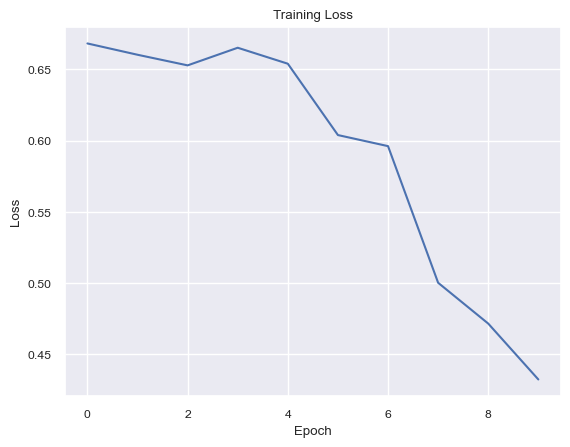

In [200]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

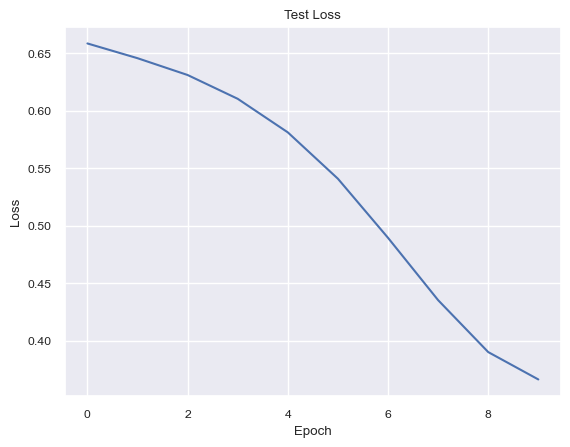

In [201]:
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

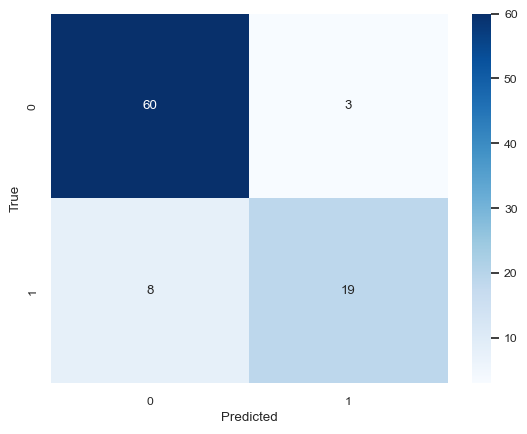

In [202]:
# Matriz de confusão
confusion = confusion_matrix(labels_test, predicted_test)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# print(confusion)

# Questão 2

2-) Implementem duas redes neurais artificiais para o problema de classificação de dígitos
escritos à mão utilizando a base de dados do MNIST, disponível em:
https://www.kaggle.com/datasets/hojjatk/mnist-dataset.

A primeira rede deve ser uma rede
neural perceptron de múltiplas camadas clássica, e a segunda deve ser uma Rede Neural
Convolucional (CNN).

Compare o desempenho das duas redes analisando a curva de erro
médio e a matriz de confusão.

## Extração dos dados

In [2]:
# Carregando as bases
file = 'MNIST/train-images.idx3-ubyte'
train_images = idx2numpy.convert_from_file(file)
file = 'MNIST/train-labels.idx1-ubyte'
train_labels = idx2numpy.convert_from_file(file)
file = 'MNIST/t10k-images.idx3-ubyte'
test_images = idx2numpy.convert_from_file(file)
file = 'MNIST/t10k-labels.idx1-ubyte'
test_labels = idx2numpy.convert_from_file(file)

In [3]:
print("test_labels: ", test_labels.shape)
print("train_labels: ", train_labels.shape)
print("train_images: ", train_images.shape)
print("test_images: ", test_images.shape)

test_labels:  (10000,)
train_labels:  (60000,)
train_images:  (60000, 28, 28)
test_images:  (10000, 28, 28)


## Rede Neural Clássica

In [10]:
# Preparando os dados
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

train_images_tensor = torch.tensor(train_images_flat, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images_flat, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [11]:
# Definição do modelo
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size1, hidden_size2):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

In [12]:
hidden_size1 = 128
hidden_size2 = 16
learning_rate = 0.001
num_epochs = 10

model = NeuralNetwork(hidden_size1, hidden_size2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Treinamento
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(loss.item())
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Validação
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for inputs_test, labels_test in test_loader:
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            
            _, predicted_test = torch.max(outputs_test.data, 1)
            all_labels.extend(labels_test.numpy())
            all_predictions.extend(predicted_test.numpy())
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()
        
        test_accuracy = correct_test / total_test
        test_losses.append(loss_test.item())
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {loss_test.item():.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/10], Train Loss: 2.0141, Train Accuracy: 0.3671, Test Loss: 1.9968, Test Accuracy: 0.4649
Epoch [2/10], Train Loss: 1.9712, Train Accuracy: 0.4712, Test Loss: 1.9765, Test Accuracy: 0.4845
Epoch [3/10], Train Loss: 1.9737, Train Accuracy: 0.4792, Test Loss: 1.9736, Test Accuracy: 0.4887
Epoch [4/10], Train Loss: 1.9279, Train Accuracy: 0.5077, Test Loss: 1.8889, Test Accuracy: 0.5721
Epoch [5/10], Train Loss: 1.8044, Train Accuracy: 0.6399, Test Loss: 1.7879, Test Accuracy: 0.6685
Epoch [6/10], Train Loss: 1.7920, Train Accuracy: 0.6699, Test Loss: 1.7840, Test Accuracy: 0.6761
Epoch [7/10], Train Loss: 1.7938, Train Accuracy: 0.6763, Test Loss: 1.7765, Test Accuracy: 0.6817
Epoch [8/10], Train Loss: 1.7623, Train Accuracy: 0.6814, Test Loss: 1.7727, Test Accuracy: 0.6853
Epoch [9/10], Train Loss: 1.7113, Train Accuracy: 0.7428, Test Loss: 1.6796, Test Accuracy: 0.7740
Epoch [10/10], Train Loss: 1.6606, Train Accuracy: 0.7879, Test Loss: 1.5879, Test Accuracy: 0.8528


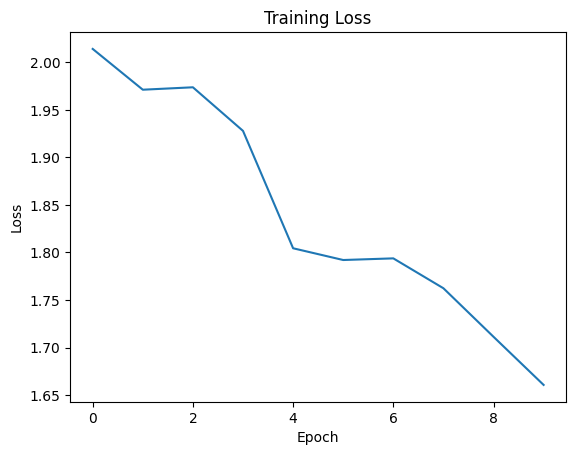

In [14]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

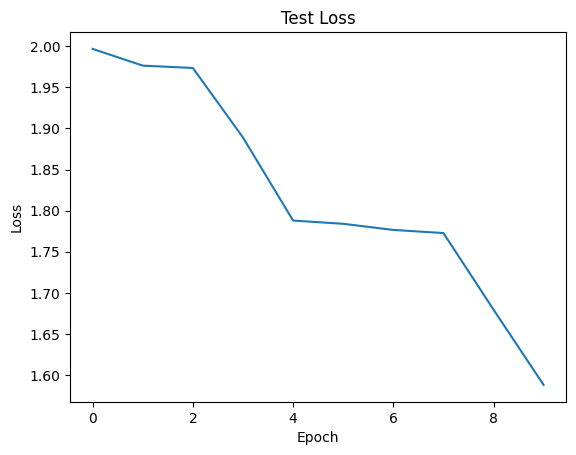

In [15]:
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

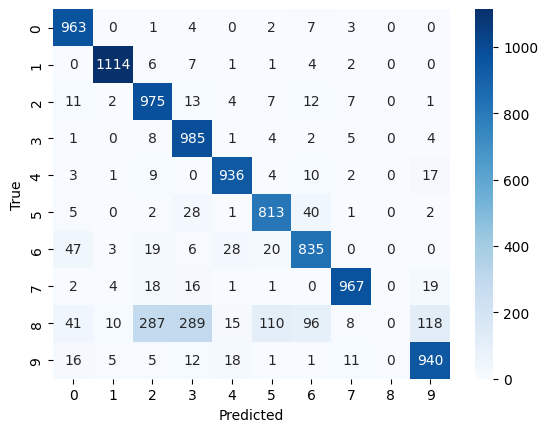

10000


In [16]:
confusion = confusion_matrix(all_labels, all_predictions)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(len(all_labels))

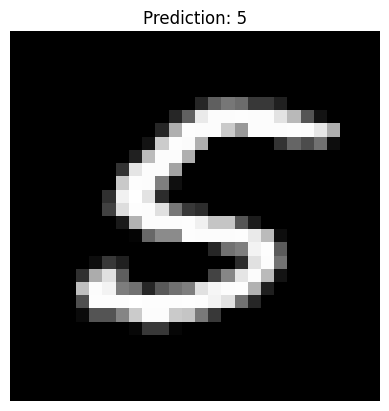

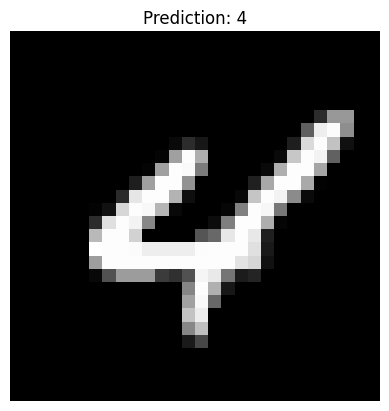

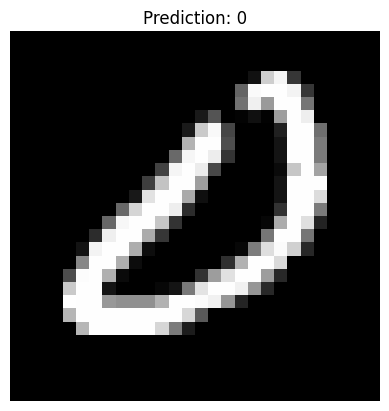

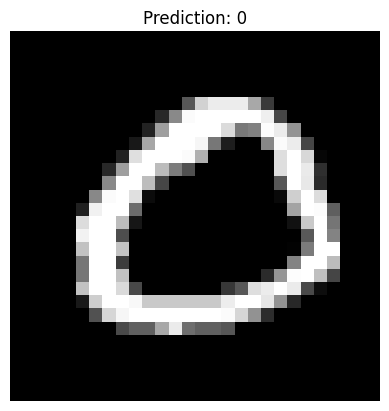

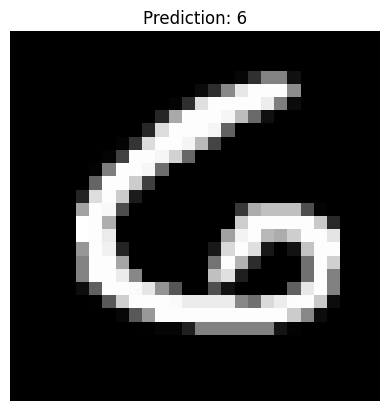

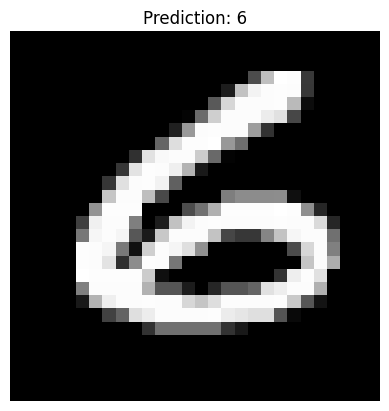

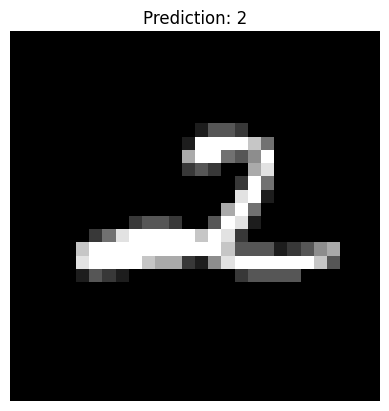

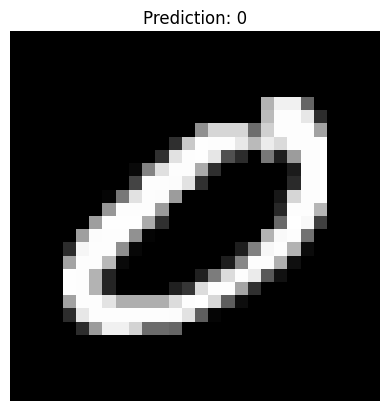

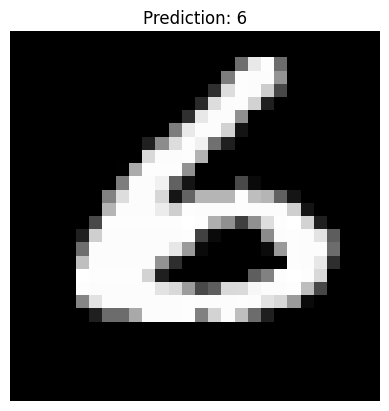

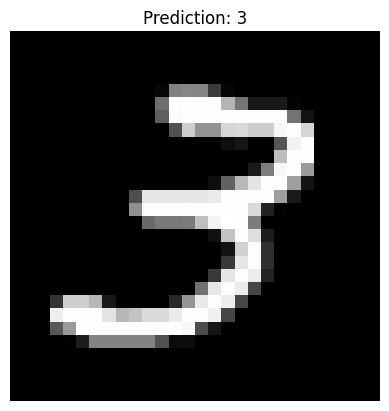

In [19]:
for i in range(10):
    first_test_image = inputs_test[i].numpy().reshape(28, 28)
    first_test_label = predicted_test[i]

    plt.imshow(first_test_image, cmap='gray') 
    plt.axis('off')
    plt.title(f"Prediction: {first_test_label.item()}") 
    plt.show()

## Rede Neural Convolucional

In [20]:
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_images_tensor = torch.unsqueeze(train_images_tensor, 1)
test_images_tensor = torch.unsqueeze(test_images_tensor, 1)

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
learning_rate = 0.001
num_epochs = 5

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Treinamento
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss = loss.item() / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validação
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for inputs_test, labels_test in test_loader:
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            
            _, predicted_test = torch.max(outputs_test, 1)
            all_labels.extend(labels_test.numpy())
            all_predictions.extend(predicted_test.numpy())
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()
        
        test_loss = loss_test.item() / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/5], Train Loss: 0.0176, Train Accuracy: 0.5638, Test Loss: 0.0679, Test Accuracy: 0.8838
Epoch [2/5], Train Loss: 0.0044, Train Accuracy: 0.9312, Test Loss: 0.0167, Test Accuracy: 0.9636
Epoch [3/5], Train Loss: 0.0028, Train Accuracy: 0.9680, Test Loss: 0.0109, Test Accuracy: 0.9771
Epoch [4/5], Train Loss: 0.0014, Train Accuracy: 0.9781, Test Loss: 0.0084, Test Accuracy: 0.9803
Epoch [5/5], Train Loss: 0.0024, Train Accuracy: 0.9824, Test Loss: 0.0066, Test Accuracy: 0.9830


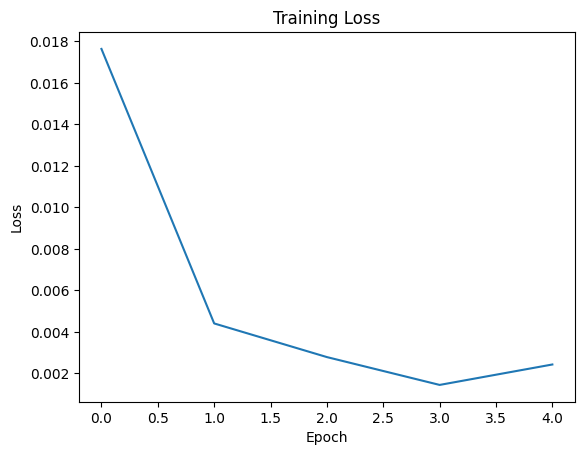

In [24]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

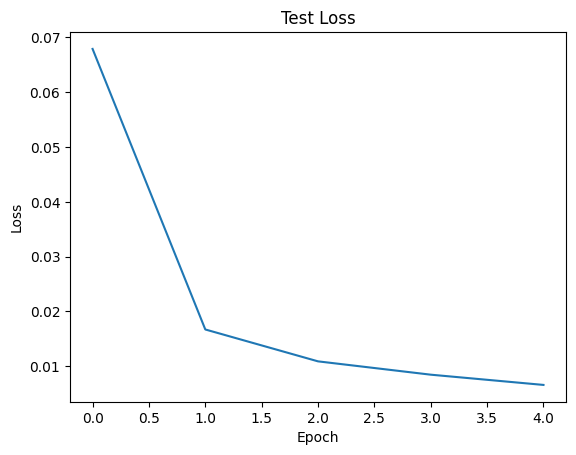

In [25]:
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

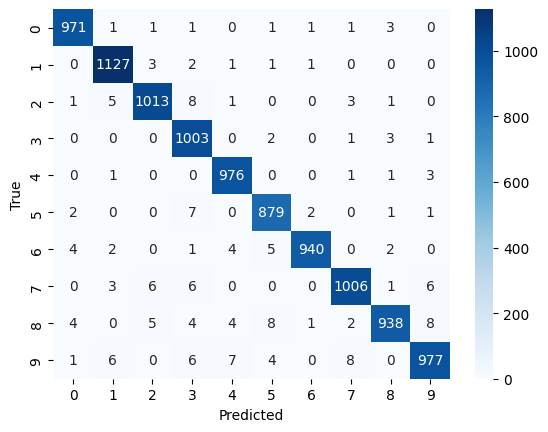

10000


In [26]:
confusion = confusion_matrix(all_labels, all_predictions)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(len(all_labels))

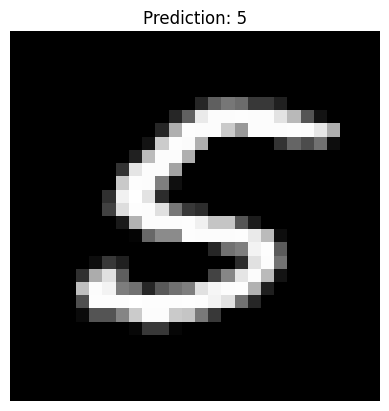

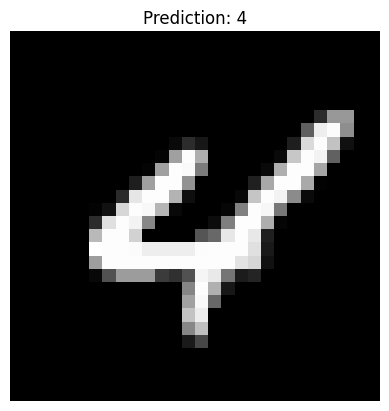

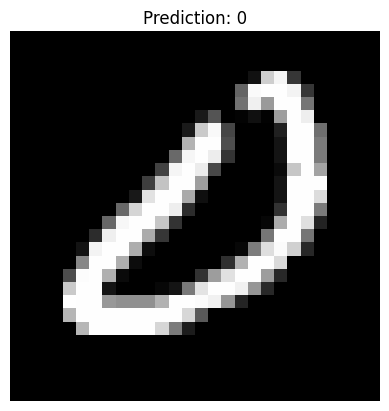

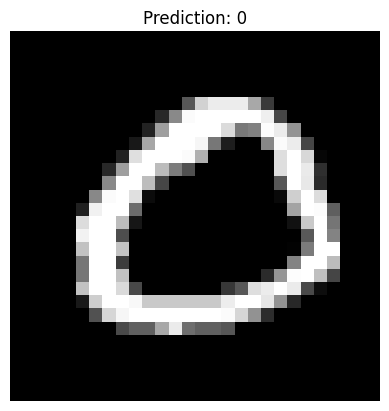

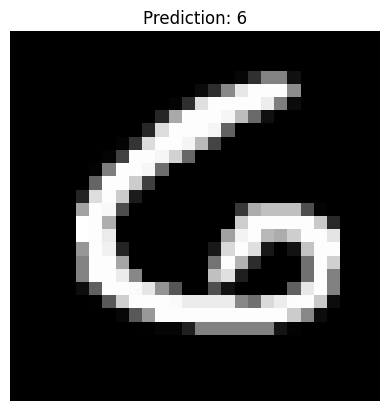

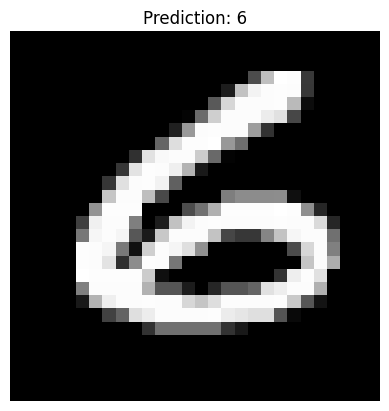

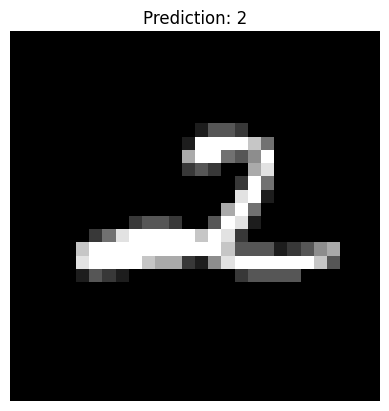

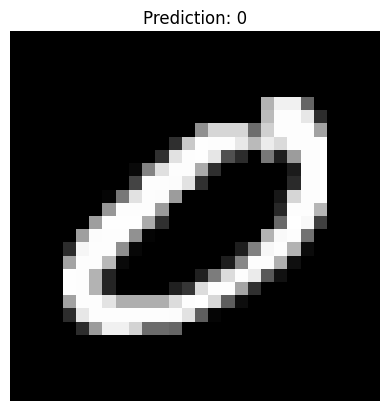

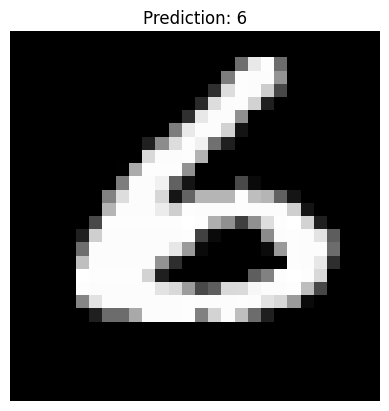

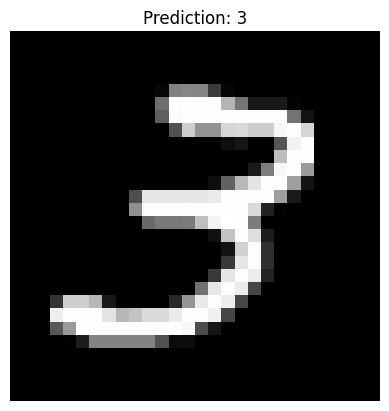

In [27]:
for i in range(10):
    first_test_image = inputs_test[i].numpy().reshape(28, 28)
    first_test_label = predicted_test[i]

    plt.imshow(first_test_image, cmap='gray') 
    plt.axis('off')
    plt.title(f"Prediction: {first_test_label.item()}") 
    plt.show()

# Questão 3

3-) Implemente uma CNN para resolver o problema de classificação de objetos em imagens
utilizando a base de dados CIFAR-10, disponível: https://www.cs.toronto.edu/~kriz/cifar.html.

Apresente também a curva do erro médio e a matriz de confusão do modelo treinado.

## Extração dos dados

In [77]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data():
    train_data = []
    train_labels = []
    for i in range(1, 6):
        data_dict = unpickle(f'cifar10/data_batch_{i}')
        if i == 1:
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']

    test_data_dict = unpickle('cifar10/test_batch')
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = load_cifar10_data()

In [41]:
train_data.shape

(50000, 3072)

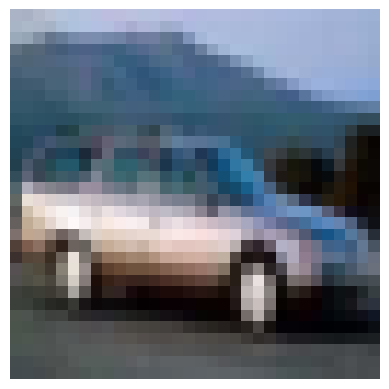

In [90]:
def display_image(data):
    R = data[0:1024].reshape(32,32)
    G = data[1024:2048].reshape(32,32)
    B = data[2048:].reshape(32,32)
    img = np.dstack((R, G, B))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

display_image(train_data[4])

In [75]:
def create_label_dict(label_names):
    label_dict = {i: name for i, name in enumerate(label_names)}
    return label_dict

label_names = unpickle('cifar10/batches.meta')
label_names 

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [85]:
label_names = ['plane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = create_label_dict(label_names)
print(label_dict)

{0: 'plane', 1: 'auto', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [63]:
train_data = train_data.reshape(train_data.shape[0], 3, 32, 32)
train_data = train_data.transpose(0, 2, 3, 1)
test_data = test_data.reshape(test_data.shape[0], 3, 32, 32)
test_data = test_data.transpose(0, 2, 3, 1)

In [64]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [65]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


In [61]:
train_data = train_data / 255.0
test_data = test_data / 255.0

## Execução do Modelo(CNN)

In [67]:
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).permute(0, 3, 1, 2)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).permute(0, 3, 1, 2)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [68]:
class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [69]:
learning_rate = 0.001
num_epochs = 15

model = CNNCifar()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Treinamento
    model.train()
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_loss = loss.item() / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validação
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for inputs_test, labels_test in test_loader:
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            
            _, predicted_test = torch.max(outputs_test, 1)
            all_labels.extend(labels_test.numpy())
            all_predictions.extend(predicted_test.numpy())
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()
        
        test_loss = loss_test.item() / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/15], Train Loss: 0.0810, Train Accuracy: 0.1610, Test Loss: 0.4093, Test Accuracy: 0.2584
Epoch [2/15], Train Loss: 0.0686, Train Accuracy: 0.3668, Test Loss: 0.3285, Test Accuracy: 0.4117
Epoch [3/15], Train Loss: 0.0574, Train Accuracy: 0.4575, Test Loss: 0.2910, Test Accuracy: 0.4875
Epoch [4/15], Train Loss: 0.0537, Train Accuracy: 0.5097, Test Loss: 0.3086, Test Accuracy: 0.4547
Epoch [5/15], Train Loss: 0.0523, Train Accuracy: 0.5318, Test Loss: 0.2603, Test Accuracy: 0.5376
Epoch [6/15], Train Loss: 0.0486, Train Accuracy: 0.5735, Test Loss: 0.2478, Test Accuracy: 0.5664
Epoch [7/15], Train Loss: 0.0428, Train Accuracy: 0.6027, Test Loss: 0.2347, Test Accuracy: 0.5945
Epoch [8/15], Train Loss: 0.0431, Train Accuracy: 0.6253, Test Loss: 0.2374, Test Accuracy: 0.5965
Epoch [9/15], Train Loss: 0.0415, Train Accuracy: 0.6402, Test Loss: 0.2336, Test Accuracy: 0.6039
Epoch [10/15], Train Loss: 0.0361, Train Accuracy: 0.6633, Test Loss: 0.2168, Test Accuracy: 0.6344
Epoch [11

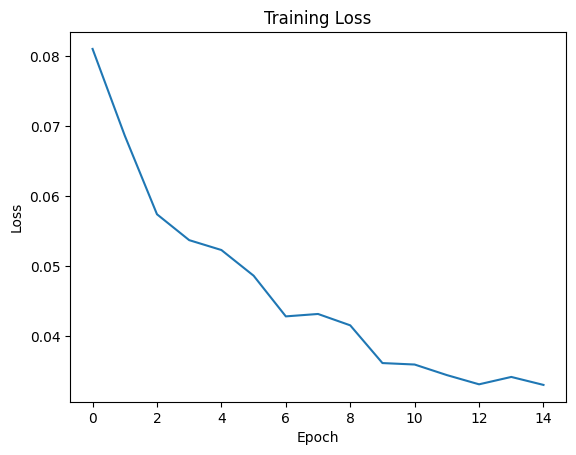

In [71]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

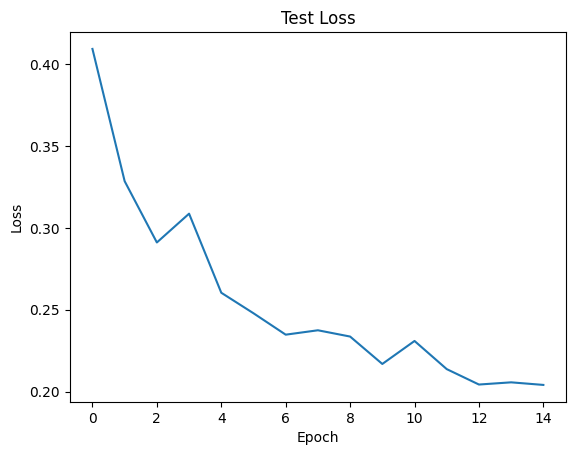

In [73]:
plt.plot(test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

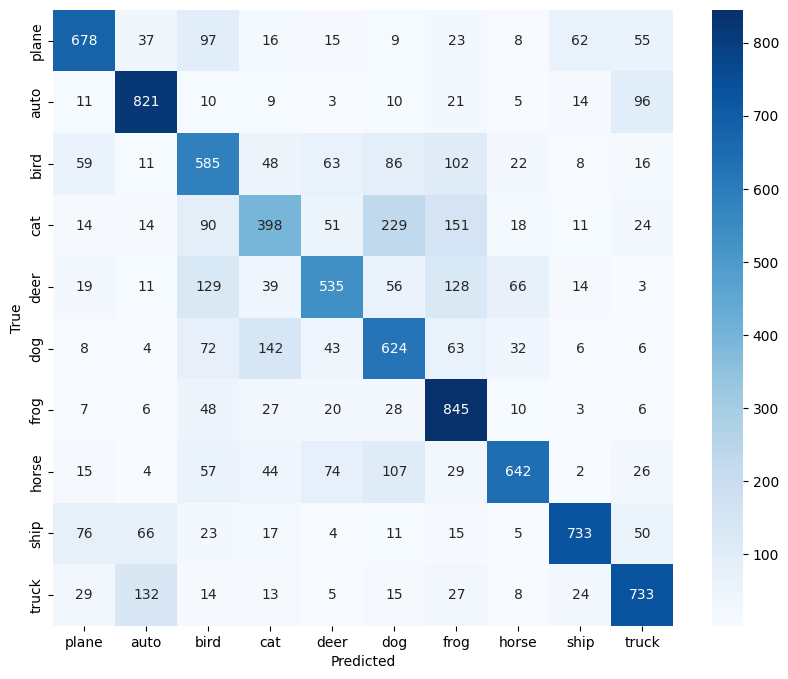

10000


In [86]:
plt.figure(figsize=(10, 8))
confusion = confusion_matrix(all_labels, all_predictions)
heatmap = sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
heatmap.set_xticklabels(label_dict.values())
heatmap.set_yticklabels(label_dict.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print(len(all_labels))

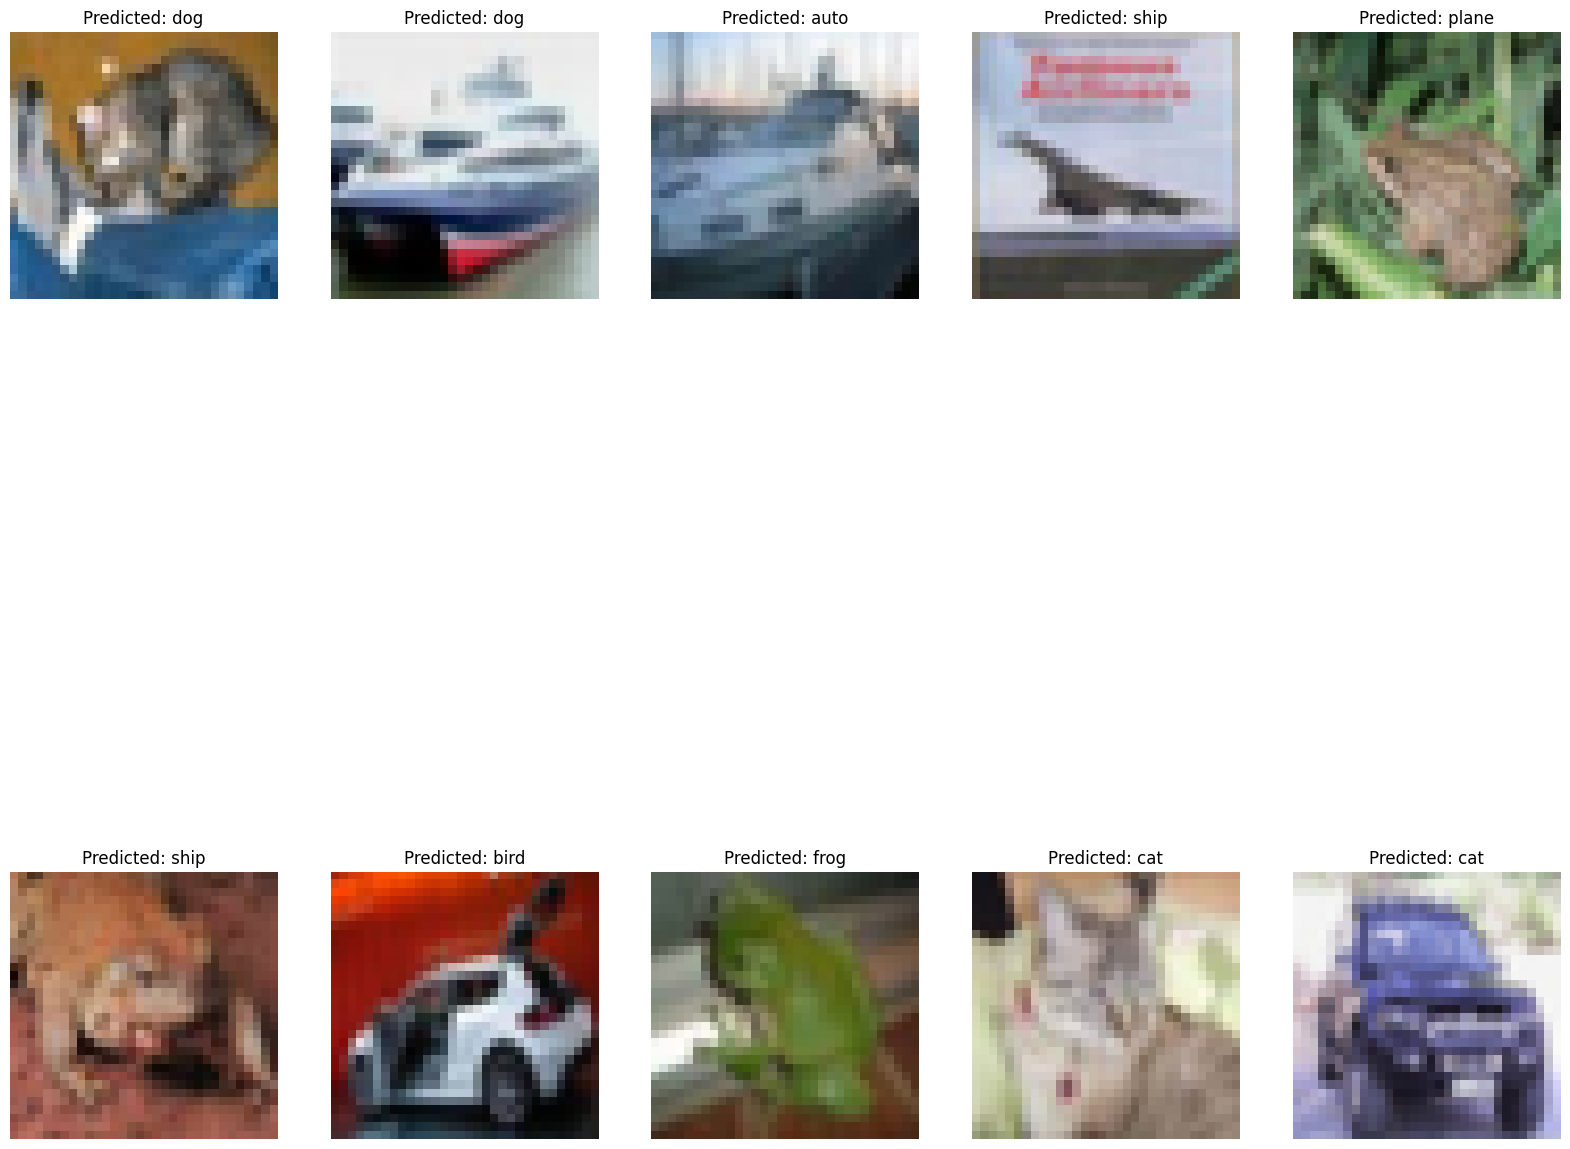

In [116]:
fig = plt.figure(figsize=(20, 20))

for i in range(10):
    img = test_data[i]
    # Reshape and reorder the image data
    img_R = img[:1024].reshape(32, 32)
    img_B = img[1024:2048].reshape(32, 32)
    img_G = img[2048:].reshape(32, 32)
    img_RGB = np.dstack((img_R, img_B, img_G))
    
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_RGB, cmap='gray')
    predicted_class = predicted_test[i].item()
    ax.set_title(f"Predicted: {label_dict[predicted_class]}")
    ax.axis('off')

plt.show()